# Kaggle Planet Competition

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys
sys.path.append('../')
from fastai.conv_learner import *
from fastai.plots import *
import planet
from planet import f2, opt_th

In [9]:
path = '../data/planet/' #path to folder containing data
sz=64   #image size
bs=20    #batch size

## Evaluation Criteria and Initial Model
If you read the evaluation criteria of competition, you will know it is based on f2 score. we define metrics for model accordingly. You can find the further information about F2 score [here](https://clusteval.sdu.dk/1/clustering_quality_measures/5).
For our initial model, we will be using pre-trained implementation of deep residual model renet34 

In [4]:
metrics=[f2]
f_model = resnet34

In [5]:
#  Prepare data Validation set
label_csv = f'{path}train_v2.csv'
n = len(list(open(label_csv)))-1 #total number of images
val_idxs = get_cv_idxs(n) #it will return 20% indexes from training data set to used for val data

In [10]:
def get_data(sz, bs):
    """Returns data generator"""
    tfms =  tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(path, 'train-jpg', f'{path}train_v2.csv', bs, tfms, suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')
data = get_data(bs, sz)

In [11]:
mdl = ConvLearner.pretrained(f_model, data, metrics=metrics)

### Finding the Learning Rate
Learning rate(LR) is one of the most important hyper parameter of your model. It determines how fast or slow your model will learn.If LR is too high, model will try to learn too fast and loss function will not converge. If LR is very too low you model will take too long to converge.

Finding a good learning rate using fastai library is very easy, just use the following two commands. They will plot a graph of LR against loss function, a good value for LR will be where the slop of the loss function is highest. As we can see slope is highest between 0.1 to 1, you can use any value in between this range. It would be a good idea to experiment with a few values in this range to find the optimal value.After experimenting with three values, 0.2 seemed to work best for me.

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[0.      0.21433 0.31313 0.79611]                            



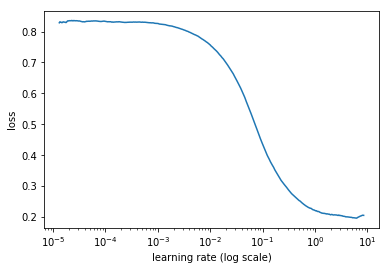

In [8]:
lrf = mdl.lr_find()
mdl.sched.plot()

### Training the model
Total size of chips in competition is 256X256, we start training our model with 64x64 and will gradually increase the size of image as training progress. This is a very good technique to avoid overfitting.

In [13]:
lr=0.2
data = get_data(64, 64) #data generator for batch size=64, image size=64x64
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)
#learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

When training the model, fastai implements a technique called stochastic gradient descent with restarts (SGDR), which trains model in cycles, where each cycle consists of one or more epochs. For each cycle, it starts with LR original value and will exponentially decrease the LR([Exponential learning rate schedule](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)) as the training progress. Second parameter in fit denotes the total number of cycles. Total number of epochs in a cycle are controlled by 2 parameter cycle_len and cycle_mult as follows.
```
number of epochs in first cycle = cycle_len 
number of epochs in second cycle = number of epochs in previous(first) cycle x cycle_mult
number of epochs in third cycle =  number of epochs in previous(second) cycle x cycle_mult
```
Here is the graph the show changes in LR for each cycle in above training.

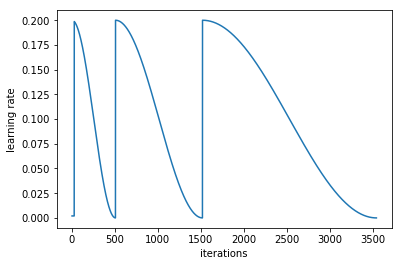

In [11]:
learn.sched.plot_lr()

By default the fastai will freeze the weights of all of the layers except a few last layers and the ones that it adds to fine-tune the model for your dataset. So in above epochs, all of learning is done by those unfrozen last layers. Next, we will unfreeze the weights of all of the layers to get more accuracy out of our model.

In [12]:
lrs = [lr/9, lr/3, lr]
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      0.11545 0.108   0.90886]                            
[1.      0.10903 0.10524 0.90852]                            
[2.      0.10599 0.10112 0.91309]                            
[3.      0.10508 0.10236 0.91269]                            
[4.      0.10246 0.09796 0.91787]                             
[5.      0.09533 0.09687 0.91742]                             
[6.      0.09683 0.09648 0.918  ]                             



If you have noticed, I have used an array for LR instead of a single value. If you give an array of 3 elements to fastai, it will divide the layers into 3 equal sets. For each set, it will use corresponding value from array.Since we are using a pre-trained model, and in a CNN initial set of layers usually learns simple features(like find a edge, corner, etc) so we don't want our initial layers to change too much, therefore we are using the lowest LR for them. Higher layers in CNN learns to find complex features (like geometrical patterns,faces etc), so having a higher rate for them would be good idea so they can adopt more rapidly to our data set.

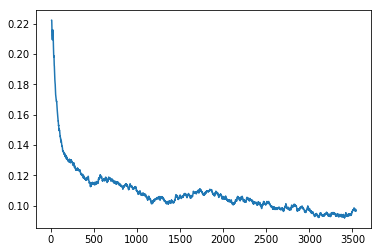

In [13]:
learn.sched.plot_loss()

In [14]:
#train for image size128x128
learn.set_data(get_data(128, 64))

learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

learn.unfreeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      0.0966  0.09547 0.917  ]                             
[1.      0.09635 0.09424 0.91865]                             
[2.      0.09327 0.09382 0.91889]                             
[3.      0.0937  0.0939  0.91869]                             
[4.      0.09337 0.09309 0.91989]                             
[5.      0.0933  0.09271 0.92085]                             
[6.      0.09105 0.09243 0.92041]                             



HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      0.09555 0.09097 0.92344]                             
[1.      0.0996  0.094   0.92096]                             
[2.      0.08956 0.0888  0.92468]                             
[3.      0.09709 0.09698 0.91835]                             
[4.      0.08934 0.08962 0.92507]                             
[5.      0.08664 0.08783 0.92663]                             
[6.      0.08306 0.08678 0.92721]                             



In [15]:
#train for image size256x256
learn.set_data(get_data(256, 64))

learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

learn.unfreeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      0.08907 0.09389 0.91971]                             
[1.      0.08899 0.09208 0.92229]                             
[2.      0.08619 0.09192 0.92249]                             
[3.      0.08887 0.09243 0.92167]                             
[4.      0.0892  0.09207 0.92242]                             
[5.      0.08694 0.09141 0.92336]                             
[6.      0.08796 0.09172 0.92282]                             



HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      0.08794 0.08569 0.92828]                             
[1.      0.0889  0.08869 0.9241 ]                             
[2.      0.08423 0.08457 0.93046]                             
[3.      0.09254 0.08826 0.92732]                             
[4.      0.08537 0.08815 0.92535]                             
[5.      0.07963 0.08324 0.93051]                             
[6.      0.0808  0.08494 0.92812]                             



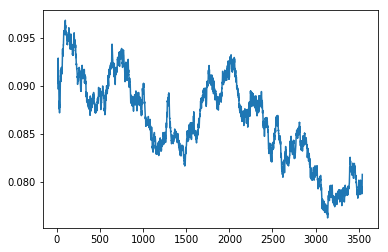

In [16]:
learn.sched.plot_loss()

fastai has another very good feature called Test Time Augmentation (TTA). The dea is simple; apply simple augmentation on each test image to generate five copies of it, and then do the prediction for each copy. You can average these prediction to get a significant(1-2%) decrease in error.

So we have trained our first model, let's see how well it performs on validation set using TTA.

In [17]:
probs = learn.predict() #returns prediction without TTA
f2_without_TTA =f2(probs, data.val_y)
probs,y = learn.TTA()
probs = np.mean(probs, axis=0)
f2_with_TTA = f2(probs, y)
print(f"F2 Score without TTA:{f2_without_TTA},   and with TTA:{f2_with_TTA}")

F2 Score without TTA:0.924895857017738,   and with TTA:0.9301386960897182


In [17]:
#dd

In [18]:
learn.save('resnet34.weights.1')

In [19]:
learn.load('resnet34.weights.1')

In [20]:
## do more data augmentation

### Preparing our first submission
In our submission file, we need to place predicted labels against each image. Each image can belong to more than one class.
```
file_10770,agriculture clear cultivation primary road
test_26732,agriculture clear cultivation haze primary
```
If you look at an example of predictions from our validation set, you will see our original labels are in the form of 1's, 0's, but our predictions are floating point numbers. So, we need to pick a threshold for our predicts to be included in submission files (0.66 for below example). op_th function tries multiple threshold in a given range and returns the one which maximizes the F2 score.

In [21]:
print(probs[0])
print(y[0])

[0.69866 0.00025 0.00766 0.00057 0.00051 0.99941 0.00003 0.00014 0.18421 0.00807 0.00021 0.00029 0.99976
 0.33801 0.0029  0.00172 0.75842]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]


In [22]:
threshold = opt_th(probs, y)
print(threshold)

0.20000000000000004


In [23]:
%time test_preds, _ = learn.TTA(is_test=True)
preds = np.mean(test_preds, axis=0)
classes = np.array(data.classes)
res = np.array([" ".join(classes[(np.where(pp>threshold))]) for pp in preds])
filenames = np.array([os.path.basename(fn).split('.')[0] for fn in data.test_ds.fnames])
frame=pd.DataFrame(res, index=filenames, columns=['tags'])
frame.to_csv(f'{path}planet_amazon_restnet34_submission1.csv', index_label='image_name')

CPU times: user 52min 39s, sys: 11min 31s, total: 1h 4min 10s
Wall time: 35min 18s


### Ensembling
Instead of training one model, we will be training multiple models and then averaging their prediction. This techniques is always employed to get more accuracy on data set

In [26]:
def get_ensumble(nmodels):
    models = list()
    
    for i in range(nmodels):
        print(f'-----Training model: {i+1}--------')
        val_idx = get_cv_idxs(n, val_pct=0.1, seed=12345) #use 10% of train data as val data
        
        data = get_data_ens(64, i, val_idx)
        learn = ConvLearner.pretrained(f_model, data, metrics=metrics)
        print('training for 64x64')
        learn.fit(lr, 2, cycle_len=1, cycle_mult=2)
        learn.unfreeze()
        learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
        
        print('training for 128x128')
        learn.set_data(get_data_ens(128, i, val_idx))
        learn.freeze()
        learn.fit(lr, 2, cycle_len=1, cycle_mult=2)
        learn.unfreeze()
        learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
        
        print('training for 256x256')
        learn.set_data(get_data_ens(256, i, val_idx))
        learn.freeze()
        learn.fit(lr, 2, cycle_len=1, cycle_mult=2)
        learn.unfreeze()
        learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
        
        
        learn.save(f'ensem_model_{i}.weights')
        np.savez_compressed(f'{path}models/ensem_model_{i}_validx', val_idx=val_idx)
        models.append(learn)
        print(f'-----Training of model {i+1} complete----')
    return models
        
    
def get_data_ens(img_sz, model_index, val_idx):
    return  ImageClassifierData.from_csv(path, 'train-jpg', f'{path}train_v2.csv', bs, get_transform(model_index, img_sz), suffix='.jpg', val_idxs=val_idx, test_name='test-jpg')

    
    
def get_transform(index, img_sz):
    f_model=resnet34
    index = (index%5)
    print(f'get_transform--{index}: {img_sz}')
    tfms = [
        tfms_from_model(f_model, img_sz, aug_tfms=transforms_basic, max_zoom=1.05),
        tfms_from_model(f_model, img_sz, aug_tfms=transforms_side_on, max_zoom=1.05),
        tfms_from_model(f_model, img_sz, aug_tfms=transforms_top_down, max_zoom=1.05),
        tfms_from_model(f_model, img_sz, aug_tfms=transforms_top_down, max_zoom=1.1),
        tfms_from_model(f_model, img_sz, aug_tfms=transforms_top_down, max_zoom=1.05, crop_type=CropType.RANDOM)]
    return tfms[index]

In [28]:
%time ens = get_ensumble(2)

-----Training model: 1--------
get_transform--0: 64
training for 64x64


HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  6%|▌         | 70/1139 [00:06<01:46, 10.07it/s, loss=0.696]

Exception in thread Thread-62:
Traceback (most recent call last):
  File "/home/huiqin/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/huiqin/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/huiqin/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[0.      0.14283 0.12677 0.88866]                              
[1.      0.13842 0.12394 0.89102]                              
[2.      0.13207 0.12001 0.89642]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      0.12177 0.10286 0.91136]                              
[1.      0.1088  0.10002 0.91629]                              
[2.      0.09736 0.0964  0.91948]                               

training for 128x128
get_transform--0: 128


HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      0.10252 0.09359 0.92271]                               
[1.      0.10024 0.09165 0.92502]                               
[2.      0.09789 0.09203 0.92227]                               



HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      0.09378 0.08693 0.92669]                               
[1.      0.09672 0.08774 0.92889]                               
[2.      0.0854  0.08576 0.92761]                               

training for 256x256
get_transform--0: 256


HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      0.09188 0.08979 0.9247 ]                               
[1.      0.0935  0.08835 0.92539]                               
[2.      0.09386 0.08996 0.9233 ]                               



HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      0.0859  0.08498 0.92914]                               
[1.      0.08983 0.08737 0.92693]                               
[2.      0.08491 0.08343 0.93208]                               

-----Training of model 1 complete----
-----Training model: 2--------
get_transform--1: 64
training for 64x64


HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      0.1498  0.12664 0.88805]                              
[1.      0.13399 0.12468 0.88869]                              
[2.      0.13605 0.11984 0.89622]                              



HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      0.11862 0.10066 0.91527]                              
[1.      0.1149  0.10566 0.91004]                              
[2.      0.10257 0.09558 0.9214 ]                               

training for 128x128
get_transform--1: 128


HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      0.10197 0.09507 0.9198 ]                               
[1.      0.09834 0.09302 0.92196]                               
[2.      0.09938 0.09188 0.92337]                               



HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      0.09989 0.08759 0.9266 ]                               
[1.      0.0953  0.08584 0.93138]                               
[2.      0.08643 0.08429 0.93113]                               

training for 256x256
get_transform--1: 256


HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      0.09438 0.08944 0.92419]                               
[1.      0.09894 0.08852 0.92492]                               
[2.      0.08969 0.08713 0.92624]                               



HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      0.09037 0.08408 0.92922]                               
[1.      0.08969 0.08378 0.9297 ]                               
[2.      0.08213 0.08298 0.93055]                               

-----Training of model 2 complete----
CPU times: user 4h 18min 59s, sys: 1h 7min 21s, total: 5h 26min 20s
Wall time: 4h 14min 37s


In [14]:
def get_ready_ensumble(nmodels):
    models = list()
    
    for i in range(nmodels):
        learn.load(f'ensem_model_{i}.weights')
        models.append(learn)
    return models

In [15]:
### Call this to load your previous models
#%time ens = get_ready_ensumble(2)

CPU times: user 81.8 ms, sys: 60.2 ms, total: 142 ms
Wall time: 642 ms


#### Preparing Submission

In [16]:
#Find optimized Threshold
ens_val_probs=list()
th_list=list()
for mdl in ens:
    val_probs, y=mdl.TTA()
    val_probs=np.mean(val_probs, axis=0)
    acc = f2(val_probs, y)
    print (f'f2 Score: {acc}')
    th =opt_th(val_probs, y)
    th_list.append(th)
    ens_val_probs.append(val_probs)
print(th_list)   
op_th = np.mean(th_list)
print(op_th)

f2 Score: 0.8507702746822222                 
f2 Score: 0.8512821552577797                 
[0.17, 0.17]
0.17


In [17]:
#Prepare test predictions
ens_test_probs = list()
for mdl in ens:
    test_probs,_ = mdl.TTA(is_test=True)
    test_probs = np.mean(test_probs, axis=0)
    ens_test_probs.append(test_probs)
ens_test_probs = np.array(ens_test_probs)
ens_test_probs = np.mean(ens_test_probs, axis=0)
ens_test_probs.shape

(61190, 17)

In [19]:
#prepare the submission file
classes = np.array(ens[0].data.classes)
res = np.array([" ".join(classes[(np.where(pp>op_th))]) for pp in ens_test_probs])
filenames = np.array([os.path.basename(fn).split('.')[0] for fn in ens[0].data.test_ds.fnames])
frame=pd.DataFrame(res, index=filenames, columns=['tags'])
frame.to_csv(f'{path}planet_amazon_restnet34_submission_ens.csv', index_label='image_name')

### A Machine Learning model for calculating threshold
When preparing submission, we used a threshold of ~0.2 to select classes for all of test images, but ideally each test image should have a separate threshold depending on the predictions values from model. I experimented with training ML model to find the better threshold but didn’t succeed. Here is the code.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, mean_squared_error

In [ ]:
def get_optimized_threshold_list(x, y):
    th_list = list()
    for truth,  preds in zip(y, x):
        steps = np.arange(0.1, 0.4, 0.01)
        acc = np.array([accuracy_score(truth, (preds > th)) for th in steps])
        th_list.append(steps[np.argmax(acc)])
    return th_list
                   
                   
def ml_model_threshold():
    arr = np.load(f'{path}models/preds_probs.npz')
    x = arr['probs']
    y = arr['y']
    th_list= get_optimized_threshold_list(x, y)
    model = make_pipeline(PolynomialFeatures(2), Ridge())
    model.fit(x, th_list)
    print (mean_squared_error(th_list, model.predict(x)))
    return model

#### Submitting Machine Learning predicitons

In [ ]:
model = ml_model_threshold()

In [ ]:
classes = np.array(data.classes)
op_th_ml = model.predict(preds)
res = np.array([" ".join(classes[(np.where(preds[i]>op_th_ml[i]))]) for i in range(len(preds))])
filenames = np.array([os.path.basename(fn).split('.')[0] for fn in data.test_ds.fnames])
frame=pd.DataFrame(res, index=filenames, columns=['tags'])
frame.to_csv(f'{path}planet_amazon_restnet34_submission2.csv', index_label='image_name')